# Tutorial 3.2: Statistical Porperties of Simulated Spike Trains
### Neuroscience goal:
- discover how different types of within-trial variability and across-trial variability impact measures such as ISI distribution and Fano factor
### Computational goals:
- analyze distributions of time differences and cumulative sumsof events
- gain practice altering size of time windows for analyzing data

In [177]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Part A: AELIF Neuron with Noise
## 1. Simulate an AELIF neuron with the following parameters:
- parameters listed in `reset_params()` function
- i_app = mean of 0, different value on each time step from normal distribution with std of sigma / sqrt(delta_t) 

### a. initially set sigma = 50pA.
- record spike times and the set of ISIs by taking the difference between spike times

In [145]:
def reset_params():
    """
    Reset global parameters and initialize variables for simulation
    """
    global e_leak, v_threshold, v_reset, delta_th, g_leak, c_membrane, a, b, tau_sra, v_peak, r_membrane

    # Define parameters
    e_leak = -70e-3           # Leak potential, mV
    v_threshold = -50e-3      # Spike threshold, mV
    v_reset = -80e-3          # Reset potential, mV
    delta_th = 2e-3           # Threshold decay, mV
    g_leak = 10e-9            # Leak conductance, S
    c_membrane = 100e-12      # Membrane capacitance, F
    r_membrane = 100e6        # Membrane resistance, Ohm
    a = 2e-9                  # I_SRA control term, S
    b = 0 #5e-10              # I_SRA current step, A
    tau_sra = 150e-3          # SRA time-constant
    v_peak = 40e-3            # Spike uptick, mV

In [246]:
def reset_time():
    global dt, tmax, t

    # Initialize time vector
    dt = 0.01e-3     
    tmax = 100
    t = np.arange(0, tmax, dt)

def reset_current(sigma=50e-12):
    global i_app
    # Initialize current vector
    i_app = np.random.normal(0, sigma/np.sqrt(dt), len(t))
    i_threshold = (v_threshold - e_leak) / r_membrane

In [247]:
reset_time()
reset_current()

In [204]:
def run_aelif(i_app=i_app, sigma=0):

    v_sim = np.zeros_like(t)
    v_sim[0] = e_leak
    i_sra = np.zeros_like(t)
    i_sra[0] = 0
    spike_times = np.zeros_like(t)

    for i in range(1, t.shape[0]):
        # new noise term each simulation
        noise = np.random.rand() * sigma * np.sqrt(dt)

        # membrane potential ODE
        dvdt = (g_leak*((e_leak - v_sim[i - 1]) + delta_th * np.exp((v_sim[i - 1] - v_threshold)/delta_th)) - i_sra[i - 1] + i_app[i]) / c_membrane

        # forward Euler update
        v_sim[i] = v_sim[i - 1] + (dt * dvdt) + noise

        # SRA current ODE 
        didt = ((a * (v_sim[i - 1] - e_leak)) - i_sra[i - 1]) / tau_sra
        # forward Euler update
        i_sra[i] = i_sra[i - 1] + (dt * didt) + noise

        if v_sim[i] > v_threshold: 
            v_sim[i] = v_reset
            i_sra[i] = i_sra[i] + b
            v_sim[i - 1] = v_peak
            spike_times[i] = 1
    
    return v_sim, spike_times#, i_sra

In [205]:
reset_params()
v_sim, spike_times = run_aelif()

In [206]:
spike_times.max()
# nice 

1.0

In [207]:
n_spikes = np.sum(spike_times)
spike_rate = n_spikes / tmax
print(f'sigma = {sigma}')
print(f'total spikes = {n_spikes}')
print(f'spike rate = {spike_rate} Hz')
# spike_rate = 86Hz when sigma=0

sigma = 5e-11
total spikes = 8692.0
spike rate = 86.92 Hz


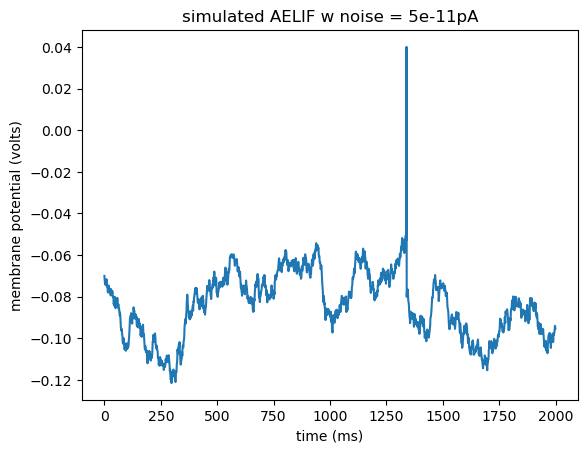

In [208]:
plt.plot(v_sim[:2000])
plt.title(f'simulated AELIF w noise = {sigma}pA')
plt.ylabel('membrane potential (volts)')
plt.xlabel('time (ms)')
plt.show()

### i. plot the histogram of ISIs 
- use 25 bins for values of ISI

In [260]:
def isi_plot(spike_times):
    spikes = np.where(spike_times)[0]
    inter_spikes = np.zeros(len(spikes) - 1)
    
    for n in range(len(inter_spikes)):
        inter_spikes[n] = spikes[n+1] - spikes[n]
    inter_spikes *= dt
    
    sns.histplot(inter_spikes, bins=25)
    plt.title('ISI distribution')
    plt.xlabel('time (s)')
    plt.ylabel('count')
    
    return inter_spikes, spikes

Text(0, 0.5, 'count')

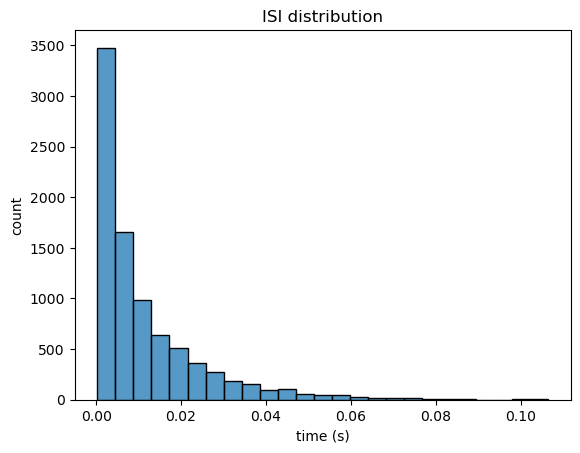

In [210]:
isi_plot()

### ii. calculate the CV of the ISIs as standard deviation divided by mean

In [219]:
cv = np.std(inter_spikes) / np.mean(inter_spikes)
print(f'Coefficient of Variation is {cv:.3}')

Coefficient of Variation is 1.16


### iii. calculate fano factor
- calculate number of spikes in each consecutive 100ms time window
- calculate variance and mean of these numbers and use results to calculate fano factor

In [220]:
n_spikes = np.zeros(1000)
t_spikes = dt*spikes

for t in t_spikes:
    bin = int(t//0.1)
    n_spikes[bin] += 1
    
fano = np.var(n_spikes) / np.mean(n_spikes)
print(f'Fano factor is {fano:.3}')

Fano factor is 1.36


### iv. repeat iii., using a loop for window size to range from 0.01 to 1s
- plot fano factor against window size

In [235]:
def plot_fano_windows(t_spikes):
    """
    plots fano factor vs window size for given t_spike array
    """
    windows = np.arange(0.01, 1.001, 0.01)
    varfano = np.zeros(len(windows))
    
    for n in range(len(windows)):
        n_spikes = np.zeros(int(np.fix(100 / windows[n])))
        for m in range(len(t_spikes)):
            temp = int(np.fix(t_spikes[m] / windows[n]))
            try:
                n_spikes[temp] += 1
            except IndexError:
                pass
            
        fano = np.var(n_spikes) / np.mean(n_spikes)
        varfano[n] = fano
        
    # plot
    plt.scatter(windows, varfano)
    plt.title('fano factor vs window size')
    plt.xlabel('window size (ms)')
    plt.ylabel('fano factor')
    plt.show()


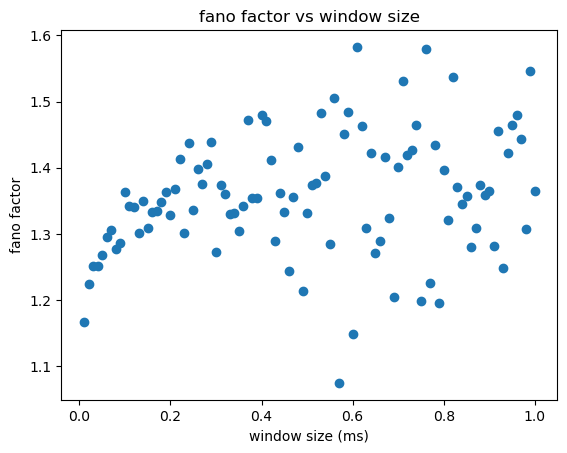

In [234]:
plot_fano_windows(t_spikes)

### b. repeat all steps of a but with AELIF parameter b = 1nA
- explain any differences in results from 1a and comment on dependences on time-window of fano factos in iv
- *hint: how does variance compare to mean of a set of values that are only 1s or 0s?*

In [248]:
reset_params()
b = 1e-9
reset_time()
reset_current()
v_sim, spike_times = run_aelif()

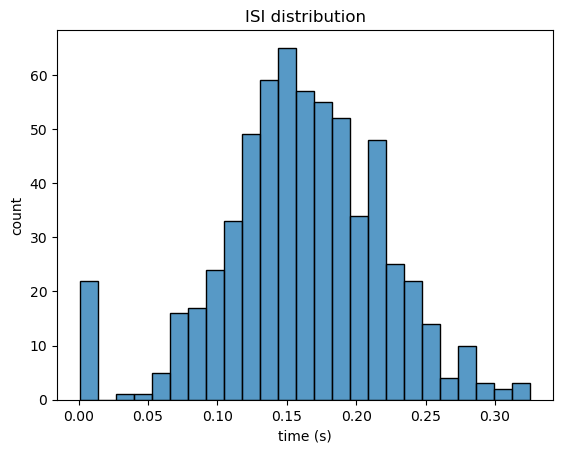

In [261]:
inter_spikes, spikes = isi_plot(spike_times)

In [262]:
cv = np.std(inter_spikes) / np.mean(inter_spikes)
print(f'Coefficient of Variation is {cv:.3}')

n_spikes = np.zeros(1000)
t_spikes = dt*spikes

for t in t_spikes:
    bin = int(t//0.1)
    n_spikes[bin] += 1
    
fano = np.var(n_spikes) / np.mean(n_spikes)
print(f'Fano factor is {fano:.3}')

Coefficient of Variation is 0.362
Fano factor is 0.481


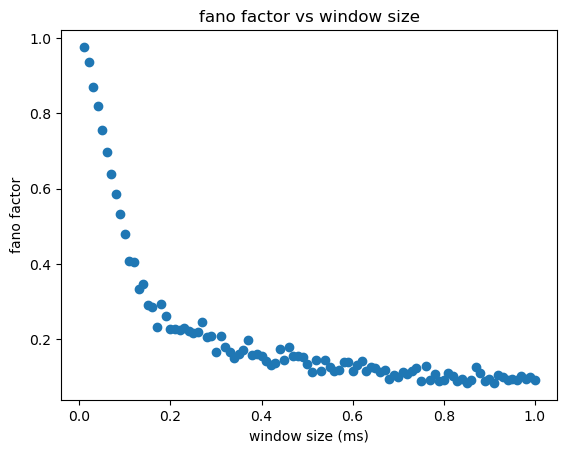

In [263]:
plot_fano_windows(t_spikes)